In [2]:
# PyTorch practice with MNIST data (Variational AutoEncoder)
# Example: https://academ-aid.com/ml/vae
# Equations:
# Kingma, D. P., & Welling, M. (2019). An Introduction to Variational Autoencoders. 
# In arXiv [cs.LG]. arXiv. http://arxiv.org/abs/1906.02691
# AK, Aug-20-2022
# =========================================================================
%reset -f
%matplotlib widget
import os, sys
from pathlib import Path
from pprint import pprint

# Define paths 
DIR_HERE = os.path.dirname(os.path.realpath("__file__"))
DIR_DLFS = os.path.join(str(Path.home()), 'Dropbox', 'w_LABWORKS', 'STUDYGROUPS', 'DeepLearningFromScratch')
DIR_LIB = os.path.join(DIR_DLFS, 'PyTorch_library')
DIR_SAVE = os.path.join(DIR_HERE, "trained_weights")
sys.path.append(DIR_LIB)

# Basic
import numpy as np
import pandas as pd
from numpy import linalg as ln
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter 

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device)

%who

Device used: cpu
DIR_DLFS	 DIR_HERE	 DIR_LIB	 DIR_SAVE	 F	 Path	 SummaryWriter	 Variable	 datasets	 
device	 ln	 nn	 np	 optim	 os	 pd	 plt	 pprint	 
summary	 sys	 torch	 transforms	 


In [3]:
# Image transoform
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1))])

#Train data (channel, height, width) = (1,28,28) 60000 images
train_dataset = datasets.MNIST(root=os.path.join(DIR_DLFS,"z_DATASETS"), 
                                        train = True, # Get training dataset
                                        download = False,
                                        transform = transform)

#Test data (channel, height, width) = (1,28,28) 10000 images
test_dataset = datasets.MNIST(root=os.path.join(DIR_DLFS,"z_DATASETS"), 
                                        train = False, # Get test dataset
                                        download = False, 
                                        transform = transform)

In [ ]:
# Equation
# x = onservations
# z = latent variable
# epsilon = noise for reparametrization trick
# p_theta(z|x) = posterior distribution of z given x
# q_theta(z|x) = a parametric inference model, approximation to the posterior (p_theta)

In [5]:
#------------------------------
# Define hyperparameters
n_epochs = 500          # how many times to repeat learning epochs
n_batch = 1000          # how many examples to give in one epoch
learning_rate = .001    # learning rate of the oprimizer
weight_decay = .001     # weight decay for optimizer

# Layer properties
n_input = 28*28         # use width of image as features (input)
n_output = 10           # number of target (i.e., unique hand-written numbers)
z_dim = 20               # dimension of latent variable
rnn_nl = 'relu'         # nonlinear update function of rnn layer


#------------------------------
# Define neural network model (Encoder, Decoder, Seq2seq)
    
class VAE(nn.Module):
    def __init__(self, x_dim, z_dim):
        # Initialize
        super(VAE, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim 
        self.eps = np.spacing(1)
        
        # Encoder (recognition) network
        self.enc_fc1 = nn.Linear(self.x_dim, 400) # Encoder Layer 1 (Input layer)
        self.enc_fc2 = nn.Linear(400, 200) # Encoder Layer 2
        self.enc_fc3_mean = nn.Linear(200, z_dim) # mean of q_theta(x|z)
        self.enc_fc3_logvar = nn.Linear(200, z_dim) # log of variance of q_theta(x|z)
        # Note: log is used here because variance cannot be negative
        
        # Decoder (generative) network
        self.dec_fc1 = nn.Linear(z_dim, 200) # Decoder Layer 1
        self.dec_fc2 = nn.Linear(200, 400) # Decoder Layer 2
        self.dec_drop = nn.Dropout(p=0.2) # Dropout before the output layer
        self.dec_fc3 = nn.Linear(400, self.x_dim) # Decoder Layer 3 (Output layer)
        

    def encoder(self, x):
        """
        Encoder layer: q_theta (z|x), data space to latent space
        (p.16 Kingma and Welling) 
        x = input data(batch, x_dim)
        (mean) = mean of q_theta(x|z)
        (log_var) = log of variance of q_theta(x|z)
        """
        # Convert data to 1D
        x = x.view(-1, self.x_dim)
        
        # Individual layers+activations
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        
        # mean of q_theta(x|z), log of variance of q_theta(x|z)
        mean = self.enc_fc3_mean(x)
        log_var = self.enc_fc3_logvar(x)
        return mean, log_var

    def sample_z(self, mean, log_var, device):
        """
        Sampling for "reparametrization trick" 
        (p.20 Kingma and Welling) 
        mean = mean of q_theta(x|z)
        log_var = log of variance of q_theta(x|z)
        (z) = latent variable (batch, z_dim)
        """
        # Externalize the randomness in z by re-parameterizing the variable 
        # as a deterministic and differentiable function of φ, x
        # and a newly introduced random variable epsilon (e.g., eq 2.40 on pg. 25)
        epsilon = torch.randn(mean.shape, device=device)
        z = mean + epsilon * torch.exp(0.5*log_var) #torch.exp(0.5*log_var) = standard deviation ~ half of variance exponentiated
        return z

    def decoder(self, z):
        """
        Decoder layer: p_theta (x|z), latent space to data space
        z = latent variable (batch, z_dim)
        (y) = output data (batch, z_dim)
        """
        # Individual layers+activations
        z = F.relu(self.dec_fc1(z))
        z = F.relu(self.dec_fc2(z))
        z = self.dec_drop(z)
        
        y = torch.sigmoid(self.dec_fc3(z))
        return y

    def forward(self, x, device):
        """
        Forward path
        x = input data(batch, x_dim)
        
        (KL) = KL divergence between q_theta(z|x) and p_theta(z|x)
        """        
        # Forward path
        mean, log_var = self.encoder(x.to(device)) # Encoder 
        z = self.sample_z(mean, log_var, device) # Reparametrization trick
        y = self.decoder(z) # Decoder
        
        # Loss function
        # KL derivation: https://ai.stackexchange.com/questions/26366/how-is-this-pytorch-expression-equivalent-to-the-kl-divergence
        KL = 0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var)) # KL divergence
        reconstruction = torch.sum(x * torch.log(y + self.eps) + (1 - x) * torch.log(1 - y + self.eps)) # Reconstruction error
        return [KL, reconstruction], z, y
        
#------------------------------
# Instantiate model
model = VAE(n_input, z_dim)
print(model)
summary(model, verbose = 2)

#------------------------------
# Define loss function
# VAE.loss!
# criterion = nn.BCELoss(reduction='sum')

#------------------------------
# Define optimier
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

#------------------------------
# Define data loader, which generates batch efficiently in PyTorch
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# https://blog.paperspace.com/dataloaders-abstractions-pytorch/

# Data loader for training
dataloader_train = torch.utils.data.DataLoader(train_dataset,
                                            batch_size = n_batch,
                                            drop_last = True,
                                            shuffle = True)

#Data loader for testing
dataloader_test = torch.utils.data.DataLoader(test_dataset, 
                                            batch_size = n_batch,
                                            drop_last = True,
                                            shuffle = False)
# Checking loader
for i, (data) in enumerate(dataloader_train):inputs, targets = data
print('done')

VAE(
  (enc_fc1): Linear(in_features=784, out_features=400, bias=True)
  (enc_fc2): Linear(in_features=400, out_features=200, bias=True)
  (enc_fc3_mean): Linear(in_features=200, out_features=20, bias=True)
  (enc_fc3_logvar): Linear(in_features=200, out_features=20, bias=True)
  (dec_fc1): Linear(in_features=20, out_features=200, bias=True)
  (dec_fc2): Linear(in_features=200, out_features=400, bias=True)
  (dec_drop): Dropout(p=0.2, inplace=False)
  (dec_fc3): Linear(in_features=400, out_features=784, bias=True)
)
Layer (type:depth-idx)                   Param #
VAE                                      --
├─Linear: 1-1                            314,000
│    └─weight                            ├─313,600
│    └─bias                              └─400
├─Linear: 1-2                            80,200
│    └─weight                            ├─80,000
│    └─bias                              └─200
├─Linear: 1-3                            4,020
│    └─weight                            ├─4,0

In [20]:
# ?SummaryWriter
# Use tensorboard to keep logs
writer = SummaryWriter(log_dir= DIR_HERE+ "/logs")

In [24]:
# #------------------------------
# # Do training (make sure to get new model, criterion, optimizer)
report = 1
tracer = {'loss_trn': [], 'loss_tst': []}
loaders = {'trn': dataloader_train, 'tst':dataloader_test}
print('---Training in progress!---')

for epoch in range(n_epochs):

    # Training and evaluation
    for phase in ['trn', 'tst']:
        # Initialize
        model.train()
        if phase == 'tst':model.eval()
        loss_sum, n_count = 0, 0
        
        # Batch loader
        for i , (inputs, targets) in (enumerate(loaders[phase])):
            # Initialize gradient of optimizer
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()
            
            # Do training only in train
            with torch.set_grad_enabled(phase == 'trn'):
                # Forward path of VAE model, calculate loss
                lower_bound, _, _ = model(inputs, device) 

                # Calculate loss: ELBO + KD
                loss = -sum(lower_bound) # loss is negative bound

                # Backward path (Backpropagation!)
                if phase == 'trn':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # Keep record 
                loss_sum += loss.cpu().detach().numpy()
                writer.add_scalar("Loss_%s/KL" % (phase), -lower_bound[0].cpu().detach().numpy(), epoch + n_count)
                writer.add_scalar("Loss_%s/Reconst" % (phase), -lower_bound[1].cpu().detach().numpy(), epoch + n_count)
                n_count += 1
    
        # Keep record 
        loss_sum = loss_sum / len(loaders[phase].dataset)
        tracer['loss_' + phase].append(loss_sum)
        if epoch > 0 and epoch % report == 0:print('Phase:{}, Epoch:{}, Loss: {:.2f}'.format(phase, epoch, loss_sum))

# Finished
print('---Done!---')
writer.close()

---Training in progress!---
Phase:trn, Epoch:1, Loss: 198.61
Phase:tst, Epoch:1, Loss: 191.00
Phase:trn, Epoch:2, Loss: 186.01
Phase:tst, Epoch:2, Loss: 171.57
Phase:trn, Epoch:3, Loss: 166.00
Phase:tst, Epoch:3, Loss: 155.19
Phase:trn, Epoch:4, Loss: 153.19
Phase:tst, Epoch:4, Loss: 144.60
Phase:trn, Epoch:5, Loss: 144.95
Phase:tst, Epoch:5, Loss: 137.67
Phase:trn, Epoch:6, Loss: 139.40
Phase:tst, Epoch:6, Loss: 133.05
Phase:trn, Epoch:7, Loss: 135.37
Phase:tst, Epoch:7, Loss: 129.56
Phase:trn, Epoch:8, Loss: 132.32
Phase:tst, Epoch:8, Loss: 126.61
Phase:trn, Epoch:9, Loss: 129.76
Phase:tst, Epoch:9, Loss: 124.11
Phase:trn, Epoch:10, Loss: 127.51
Phase:tst, Epoch:10, Loss: 121.88
Phase:trn, Epoch:11, Loss: 125.40
Phase:tst, Epoch:11, Loss: 119.89
Phase:trn, Epoch:12, Loss: 123.49
Phase:tst, Epoch:12, Loss: 117.96
Phase:trn, Epoch:13, Loss: 121.98
Phase:tst, Epoch:13, Loss: 116.57
Phase:trn, Epoch:14, Loss: 120.80
Phase:tst, Epoch:14, Loss: 115.45
Phase:trn, Epoch:15, Loss: 119.63
Phas

In [25]:
#------------------------------
# Save weight parameters
model_path = os.path.join(DIR_SAVE,'VAE_MNIST_20_units.pth')
torch.save(model.state_dict(), model_path)

# Save tracer
# model_path = os.path.join(DIR_SAVE,'VAE_MNIST_10_traces.pkl')
# with open(model_path, 'wb') as f:pickle.dump(tracer, f)

# Look at tracce using tensorboard
%load_ext tensorboard
%tensorboard --logdir ./logs

# # # Loading pre-trained data
model_path = os.path.join(DIR_SAVE,'VAE_MNIST_20_units.pth')
model.load_state_dict(torch.load(model_path, map_location=device))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 24020), started 13:26:44 ago. (Use '!kill 24020' to kill it.)

<All keys matched successfully>

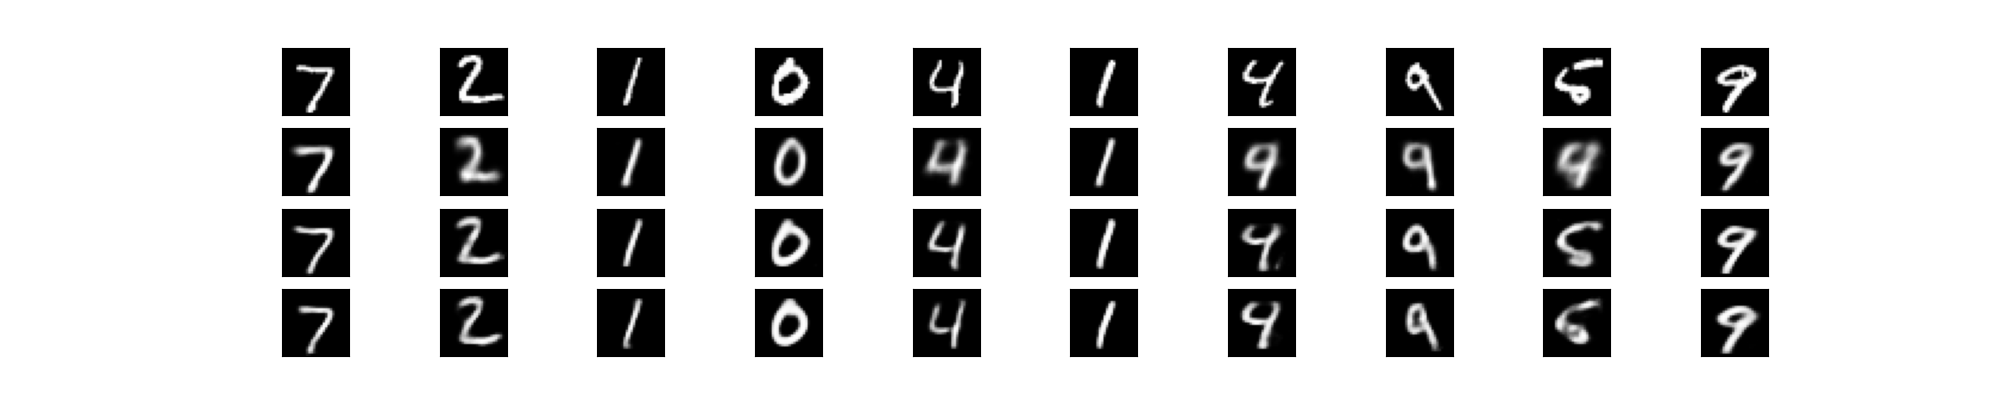

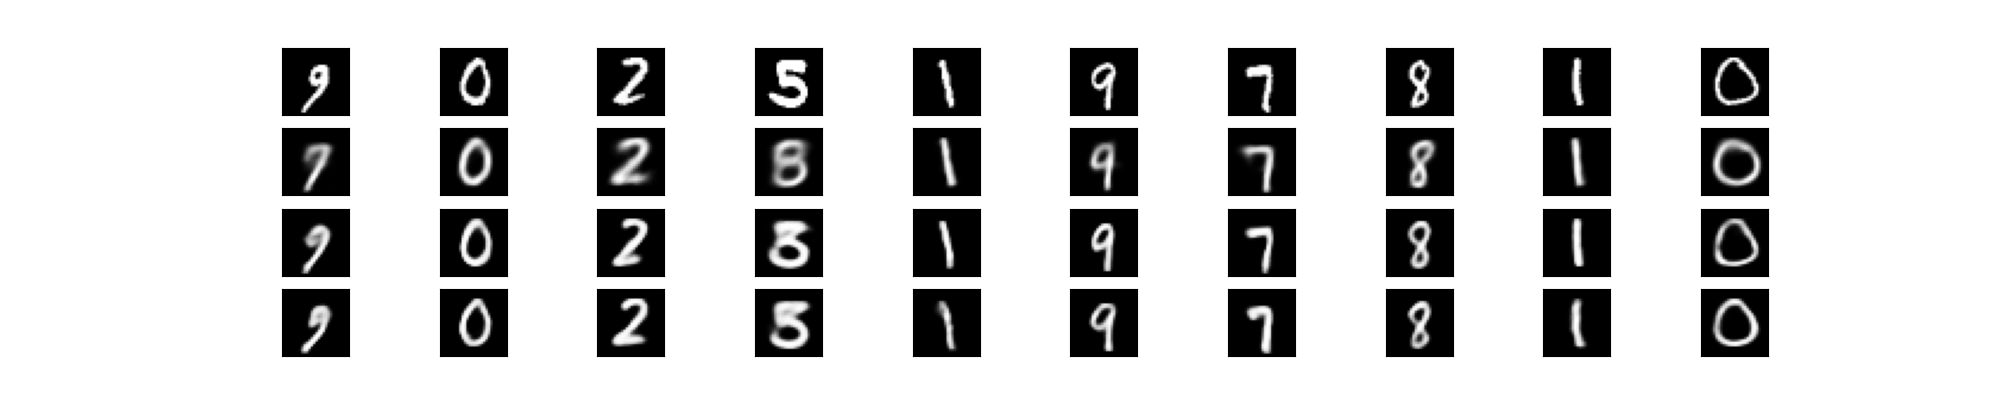

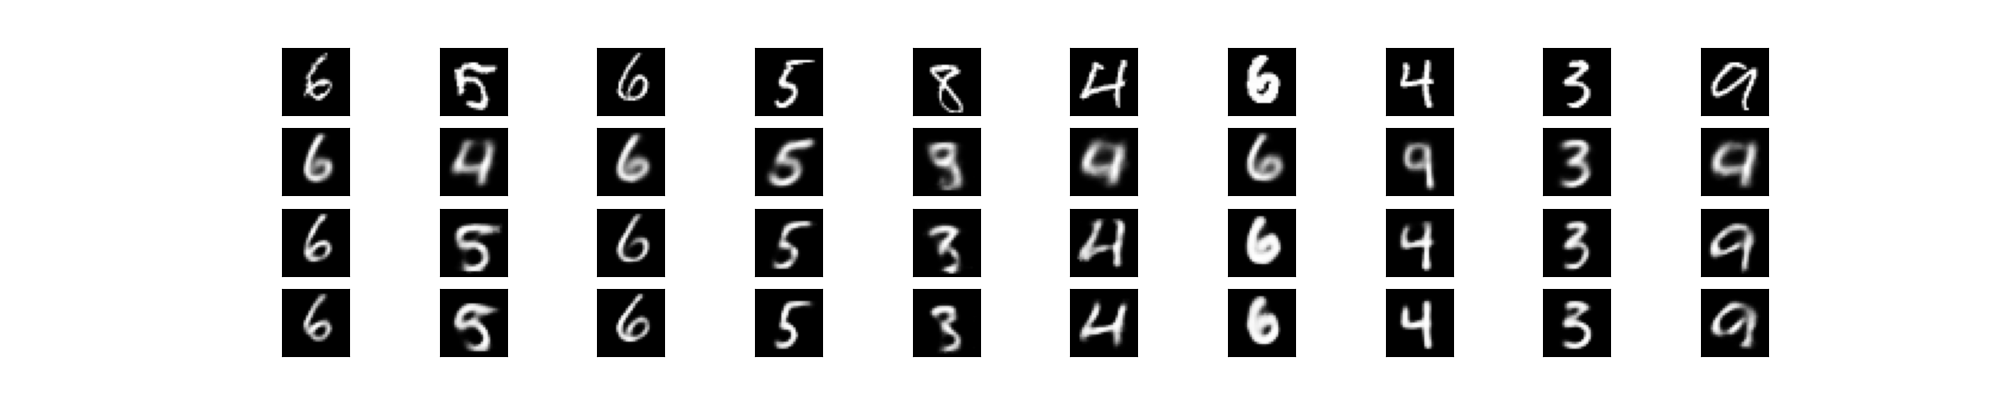

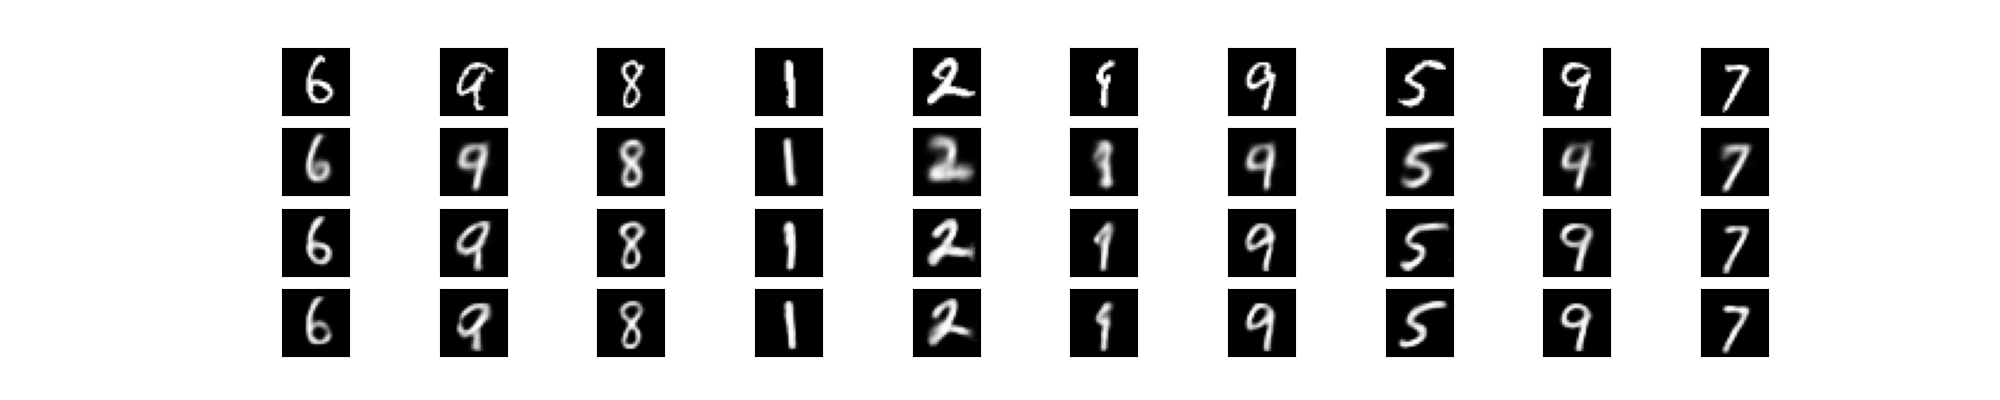

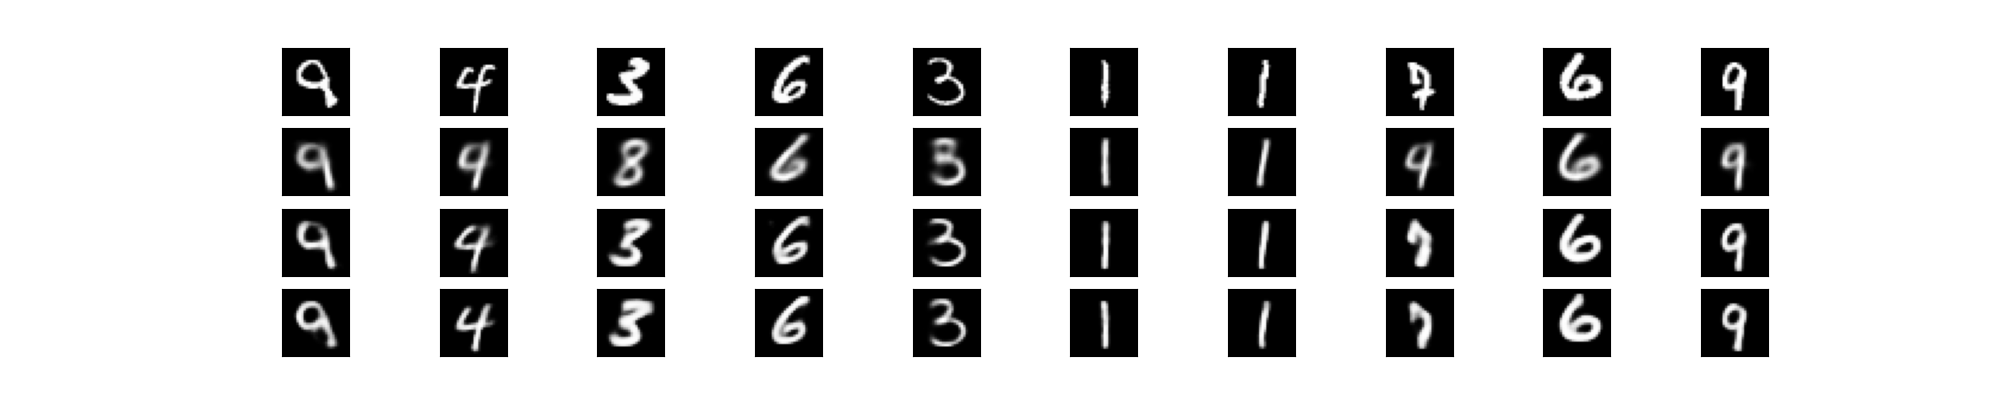

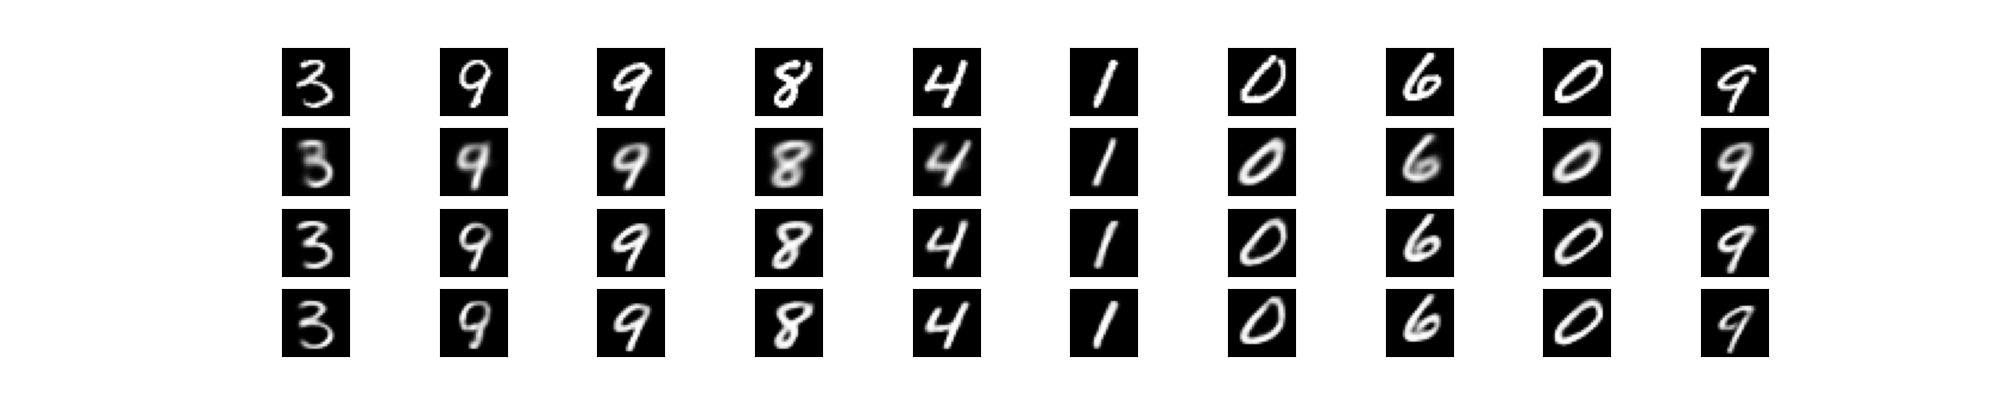

In [ ]:
# =========================
# Plot reconstructed inputs
# =========================

# Load traind weights of models variable latent dimensions
modelL = list()
z_dimL = [2, 10, 20]
for z in np.array(z_dimL):
    model = VAE(n_input, z)
    model_path = os.path.join(DIR_SAVE,'VAE_MNIST_%d_units.pth' % z)
    model.load_state_dict(torch.load(model_path, map_location=device))
    modelL.append(model)

# Plot
for num_batch, data in enumerate(dataloader_test):
    fig, axes = plt.subplots(4, 10, figsize=(20, 4))
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]): 
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])
            
    # True input
    for i, im in enumerate(data[0].view(-1, 28, 28)[:10]):
        axes[0][i].imshow(im, "gray")
        
    # Reconstruction given input data
    for i, model in enumerate(modelL):
        _, _, y = model(data[0], device)
        y = y.cpu().detach().numpy().reshape(-1, 28, 28)
        for j, im in enumerate(y[:10]):
            axes[i+1][j].imshow(im, "gray")
            
    plt.show()    

In [ ]:
# =========================
# Plot latent space
# =========================

In [ ]:
# =========================
# Walk latent space and reconstruct
# =========================